In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scanpy as sc
from scipy.stats import spearmanr, pearsonr

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Scanpy settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

celltype = 'all'
master_dir = ''

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.5.4 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1


In [4]:
# Name of results file 
results_file_all_genes = master_dir + 'output/' + celltype + '-processed-analyzed.h5ad'
results_file_metab_genes = master_dir + 'output/' + celltype + '-processed-analyzed-metab.h5ad'

# Read in counts matrix
#adata_cd8 = sc.read_h5ad(master_dir + 'data/PBMC_processed/fo8_thru_in8_GEX_for_CD8.h5ad')
#adata_cd4 = sc.read_h5ad(master_dir + 'data/PBMC_processed/fo8_thru_in8_GEX_for_CD4.h5ad')
#adata_b = sc.read_h5ad(master_dir + 'data/PBMC_processed/fo8_thru_in8_GEX_for_B_wo_patient4.h5ad')
#adata_nk = sc.read_h5ad(master_dir + 'data/PBMC_processed/fo8_thru_in8_GEX_for_NK.h5ad')
#adata_mono = sc.read_h5ad(master_dir + 'data/PBMC_processed/fo8_thru_in8_GEX_for_MONOCYTES.h5ad')

In [5]:
# Concatenate
#adata = sc.AnnData.concatenate(adata_cd8, adata_cd4, adata_b, adata_nk, adata_mono, 
#                          batch_key='cell_type', batch_categories=['cd8', 'cd4', 'b_wo_patient4', 'nk', 'mono'])

In [6]:
#adata.write(master_dir + 'data/PBMC_processed/fo8_thru_in8_GEX_for_ALL.h5ad')
adata = sc.read_h5ad(master_dir + 'data/PBMC_processed/fo8_thru_in8_GEX_for_ALL.h5ad')

In [7]:
#del adata_cd8
#del adata_cd4
#del adata_b
#del adata_nk
#del adata_mono

In [8]:
# Loading in metabolics-relevant pathways from KEGG (based on Xiao et al. Nat Commun 2019)
#metab_pathway_list = pd.read_csv(master_dir + 'data/MSigDB/KEGG_metab_pathway_list_Xiao2019-JLmod200620.txt', 
#                                 sep='\t', header=None)
#metab_pathway_list = np.array(metab_pathway_list.iloc[:, 0])

# Genes in each KEGG pathway
metab_genes = pd.read_csv(master_dir + 'data/KEGG_genesets/hsa00001.metab.keg.gmt', 
                          sep='\t', header=None)
metab_genes.index = metab_genes.iloc[:, 0]
metab_genes = metab_genes.drop([0], axis=1)
#for geneset in metab_genes.index:
#    if metab_genes.loc[geneset, 1] not in metab_pathway_list:
#        metab_genes = metab_genes.drop(geneset, axis=0)
metab_pathway_list = metab_genes.index
metab_genes.head()

1       2     3      4    \
0                                                                       
Glycolysis / Gluconeogenesis                LDHC     HK3  LDHB   PFKP   
Citrate cycle (TCA cycle)                   DLST    ACO1    CS  IDH3B   
Pentose phosphate pathway                   PFKP   ALDOA  RPIA  ALDOB   
Pentose and glucuronate interconversions  UGT2B4  UGT2A1  XYLB  CRYL1   
Fructose and mannose metabolism              HK3  PFKFB3  PFKP   FCSK   

                                              5       6      7        8    \
0                                                                           
Glycolysis / Gluconeogenesis                ALDOA   ALDOB   ADH6   GAPDHS   
Citrate cycle (TCA cycle)                    ACLY  SUCLG2   DLAT    IDH3A   
Pentose phosphate pathway                    H6PD     RPE  RPEL1  PRPS1L1   
Pentose and glucuronate interconversions  UGT2B17  UGT1A3   UGDH   UGT1A4   
Fructose and mannose metabolism             ALDOA   ALDOB   GFUS     TPI1   

                                             9     10   ...  124  125  126  \
0                                                       ...                  
Glycolysis / Gluconeogenesis                DLAT  PGM1  ...  NaN  NaN  NaN   
Citrate cycle (TCA cycle)                 SUCLA2  PDHB  ...  NaN  NaN  NaN   
Pentose phosphate pathway                   PFKM  RBKS  ...  NaN  NaN  NaN   
Pentose and glucuronate interconversions  UGT1A8  UGP2  ...  NaN  NaN  NaN   
Fructose and mannose metabolism             PMM2  SORD  ...  NaN  NaN  NaN   

                                          127  128  129  130  131  132  133  
0                                                                            
Glycolysis / Gluconeogenesis              NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Citrate cycle (TCA cycle)                 NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Pentose phosphate pathway                 NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Pentose and glucuronate interconversions  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Fructose and mannose metabolism           NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 133 columns]

In [9]:
# Get a flat array of metabolism-related genes
metab_gene_list = np.array(metab_genes.iloc[:, 1:]).flatten().astype(str)
metab_gene_list = metab_gene_list[metab_gene_list != 'nan']
len(metab_gene_list)

2841

In [10]:
# Make a new data object with only the metabolic genes from the KEGG pathways
metab_gene_list_overlap = list(set(metab_gene_list).intersection(set(adata.var_names)))
adata_metab = adata[:, metab_gene_list_overlap]
len(metab_gene_list_overlap)

1387

In [11]:
# Convert the metabolic pathways dataframe into a dictionary for GSEA
metab_genes_dict = metab_genes.transpose().to_dict(orient='series')
for element in metab_genes_dict:
    # Only include the genes that are also found in the single cell sequencing
    metab_genes_dict[element] = list(set(metab_genes_dict[element]).intersection(set(adata.var_names)))
    #metab_genes_dict[element] = metab_genes_dict[element][metab_genes_dict[element] != 'nan']
#metab_genes_dict['Glycolysis / Glucogeneogenesis_test'] = ['ACSS1', 'GAPDH']

In [12]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:05:18)


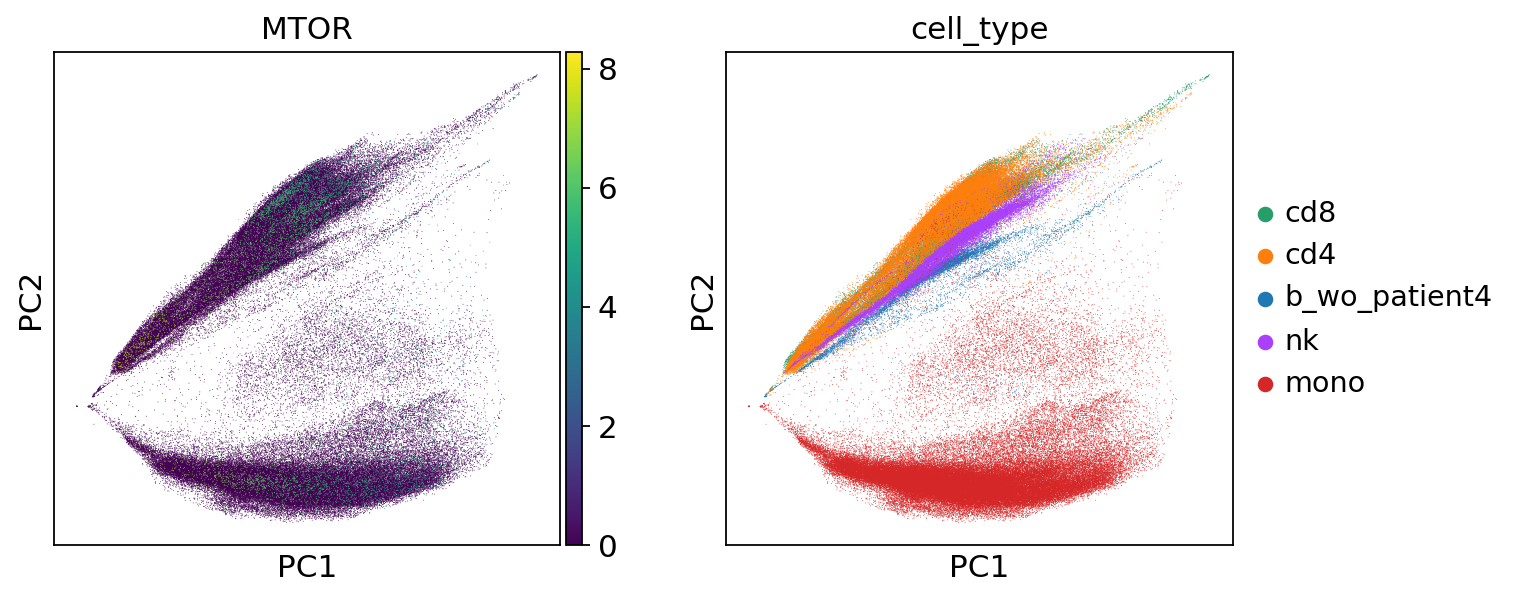

In [13]:
fig = sc.pl.pca(adata, color=['MTOR', 'cell_type'])

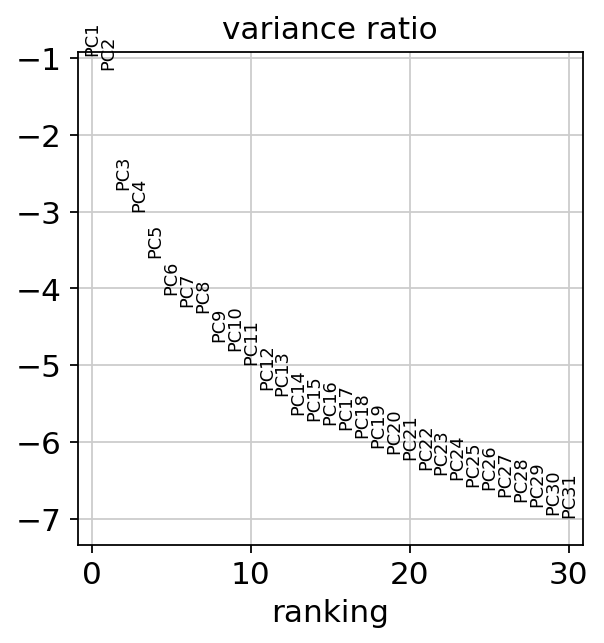

In [14]:
sc.pl.pca_variance_ratio(adata, log=True)

In [15]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:56)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:05:25)


In [18]:
adata.obs

patient ICU_status IL6i_between_draws  \
AAACCTGAGATGTAAC-1-Mix-cd8       Mix_donor1    Healthy            Healthy   
AAACCTGAGGGCTTGA-1-Mix-cd8       Mix_donor1    Healthy            Healthy   
AAACCTGCATGGGACA-1-Mix-cd8       Mix_donor1    Healthy            Healthy   
AAAGCAACAGCTGCAC-1-Mix-cd8       Mix_donor1    Healthy            Healthy   
AAAGTAGGTAGATTAG-1-Mix-cd8       Mix_donor1    Healthy            Healthy   
...                                     ...        ...                ...   
TTTGTCAAGCGTGTCC-1-C6:36-1-mono        36-1    Non-ICU                 no   
TTTGTCAAGGGCACTA-1-C6:36-1-mono        36-1    Non-ICU                 no   
TTTGTCACATGACGGA-1-C6:36-1-mono        36-1    Non-ICU                 no   
TTTGTCATCACATAGC-1-C6:36-1-mono        36-1    Non-ICU                 no   
TTTGTCATCTACTATC-1-C6:36-1-mono        36-1    Non-ICU                 no   

                                 no_IL6i  WHO_scale Blood_draw_time     Sex  \
AAACCTGAGATGTAAC-1-Mix-cd8       Healthy          0         Healthy  Female   
AAACCTGAGGGCTTGA-1-Mix-cd8       Healthy          0         Healthy  Female   
AAACCTGCATGGGACA-1-Mix-cd8       Healthy          0         Healthy  Female   
AAAGCAACAGCTGCAC-1-Mix-cd8       Healthy          0         Healthy  Female   
AAAGTAGGTAGATTAG-1-Mix-cd8       Healthy          0         Healthy  Female   
...                                  ...        ...             ...     ...   
TTTGTCAAGCGTGTCC-1-C6:36-1-mono       no          7              T1    Male   
TTTGTCAAGGGCACTA-1-C6:36-1-mono       no          7              T1    Male   
TTTGTCACATGACGGA-1-C6:36-1-mono       no          7              T1    Male   
TTTGTCATCACATAGC-1-C6:36-1-mono       no          7              T1    Male   
TTTGTCATCTACTATC-1-C6:36-1-mono       no          7              T1    Male   

                                Age_at_baseline Days_since_onset_of_symptoms  \
AAACCTGAGATGTAAC-1-Mix-cd8         Not Recorded                      Healthy   
AAACCTGAGGGCTTGA-1-Mix-cd8         Not Recorded                      Healthy   
AAACCTGCATGGGACA-1-Mix-cd8         Not Recorded                      Healthy   
AAAGCAACAGCTGCAC-1-Mix-cd8         Not Recorded                      Healthy   
AAAGTAGGTAGATTAG-1-Mix-cd8         Not Recorded                      Healthy   
...                                         ...                          ...   
TTTGTCAAGCGTGTCC-1-C6:36-1-mono              51                        12.29   
TTTGTCAAGGGCACTA-1-C6:36-1-mono              51                        12.29   
TTTGTCACATGACGGA-1-C6:36-1-mono              51                        12.29   
TTTGTCATCACATAGC-1-C6:36-1-mono              51                        12.29   
TTTGTCATCTACTATC-1-C6:36-1-mono              51                        12.29   

                                cell_type  Days_since_onset_float  \
AAACCTGAGATGTAAC-1-Mix-cd8            cd8                   -1.00   
AAACCTGAGGGCTTGA-1-Mix-cd8            cd8                   -1.00   
AAACCTGCATGGGACA-1-Mix-cd8            cd8                   -1.00   
AAAGCAACAGCTGCAC-1-Mix-cd8            cd8                   -1.00   
AAAGTAGGTAGATTAG-1-Mix-cd8            cd8                   -1.00   
...                                   ...                     ...   
TTTGTCAAGCGTGTCC-1-C6:36-1-mono      mono                   12.29   
TTTGTCAAGGGCACTA-1-C6:36-1-mono      mono                   12.29   
TTTGTCACATGACGGA-1-C6:36-1-mono      mono                   12.29   
TTTGTCATCACATAGC-1-C6:36-1-mono      mono                   12.29   
TTTGTCATCTACTATC-1-C6:36-1-mono      mono                   12.29   

                                leiden_per_cell_type louvain_per_cell_type  \
AAACCTGAGATGTAAC-1-Mix-cd8                       nan                     1   
AAACCTGAGGGCTTGA-1-Mix-cd8                       nan                     5   
AAACCTGCATGGGACA-1-Mix-cd8                       nan                     1   
AAAGCAACAGCTGCAC-1-Mix-cd8                       nan        

In [20]:
# Relabel leiden and louvain because they are per cell type
#adata.obs['leiden_per_cell_type'] = adata.obs['leiden'].copy()
#adata.obs['louvain_per_cell_type'] = adata.obs['louvain'].copy()
#adata.obs = adata.obs.drop(columns=['leiden', 'louvain'])
adata.obs = adata.obs.drop(columns=['louvain'])

In [31]:
sc.tl.louvain(adata, resolution=0.1)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:38)


In [32]:
# Reorder cell type colors to be consistent with the flux analysis plot
adata.uns['cell_type_colors'] = ['#279e68', '#ff7f0e', '#1f77b4', '#aa40fc', '#d62728']

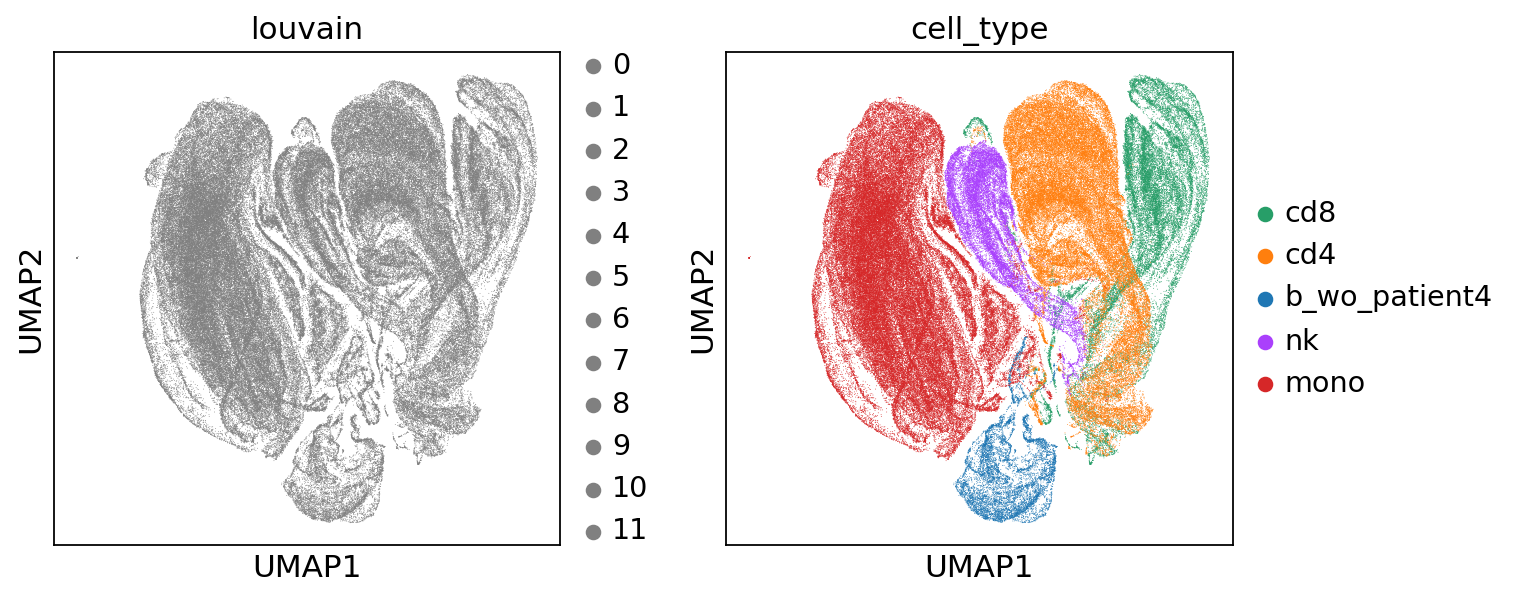

In [33]:
fig = sc.pl.umap(adata, color=['louvain', 'cell_type'])

In [34]:
adata.obs['Days_since_onset_float'] = adata.obs['Days_since_onset_of_symptoms'].apply(lambda x:float(x) if x!= 'Healthy' else -1).astype(float)

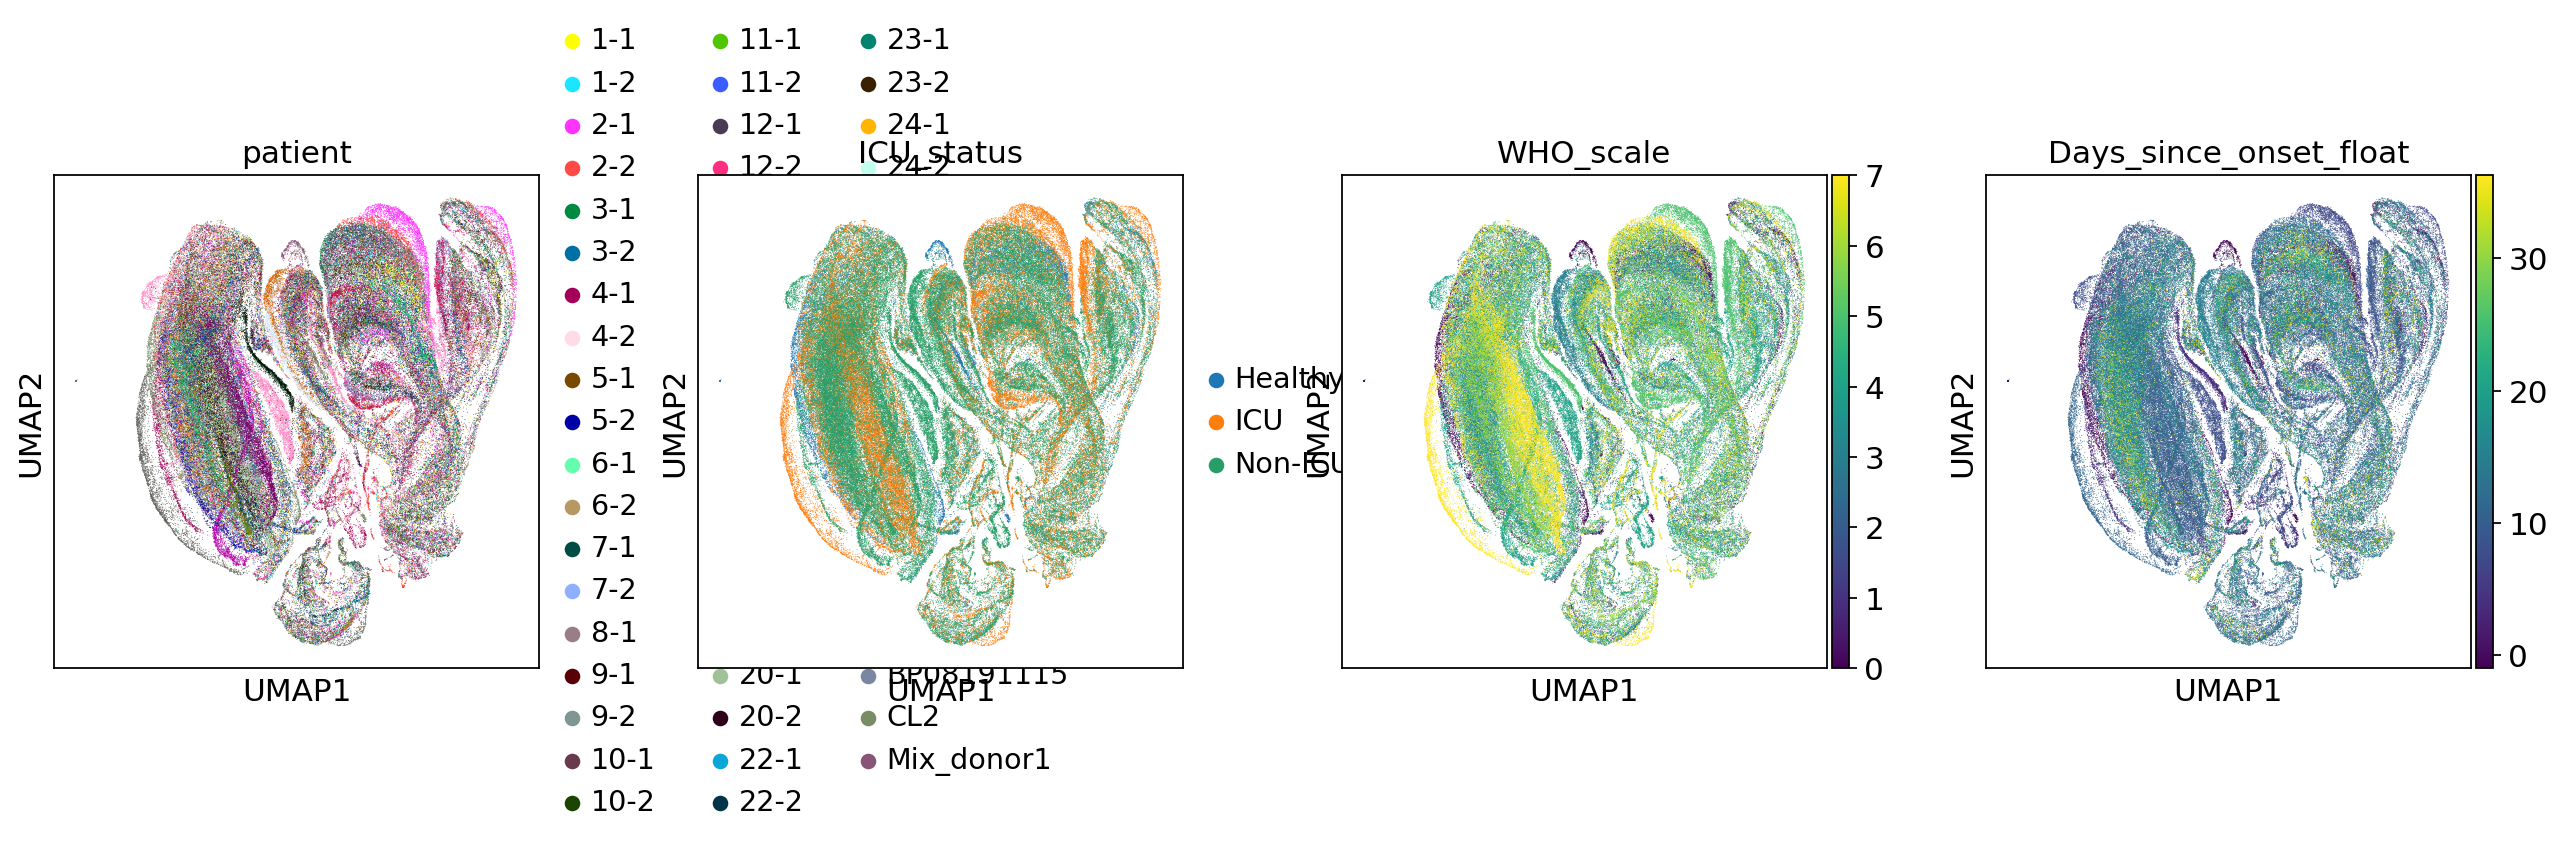

In [35]:
fig = sc.pl.umap(adata, color=['patient', 'ICU_status', 'WHO_scale', 'Days_since_onset_float'], use_raw=False)

In [36]:
sc.tl.embedding_density(adata, basis='umap', groupby='ICU_status')

computing density on 'umap'
--> added
    'umap_density_ICU_status', densities (adata.obs)
    'umap_density_ICU_status_params', parameter (adata.uns)


/home/jwlee/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/__init__.py:1156: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  color_map.set_over('black')
/home/jwlee/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/__init__.py:1157: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  color_map.set_under('lightgray')
/home/jwlee/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecat

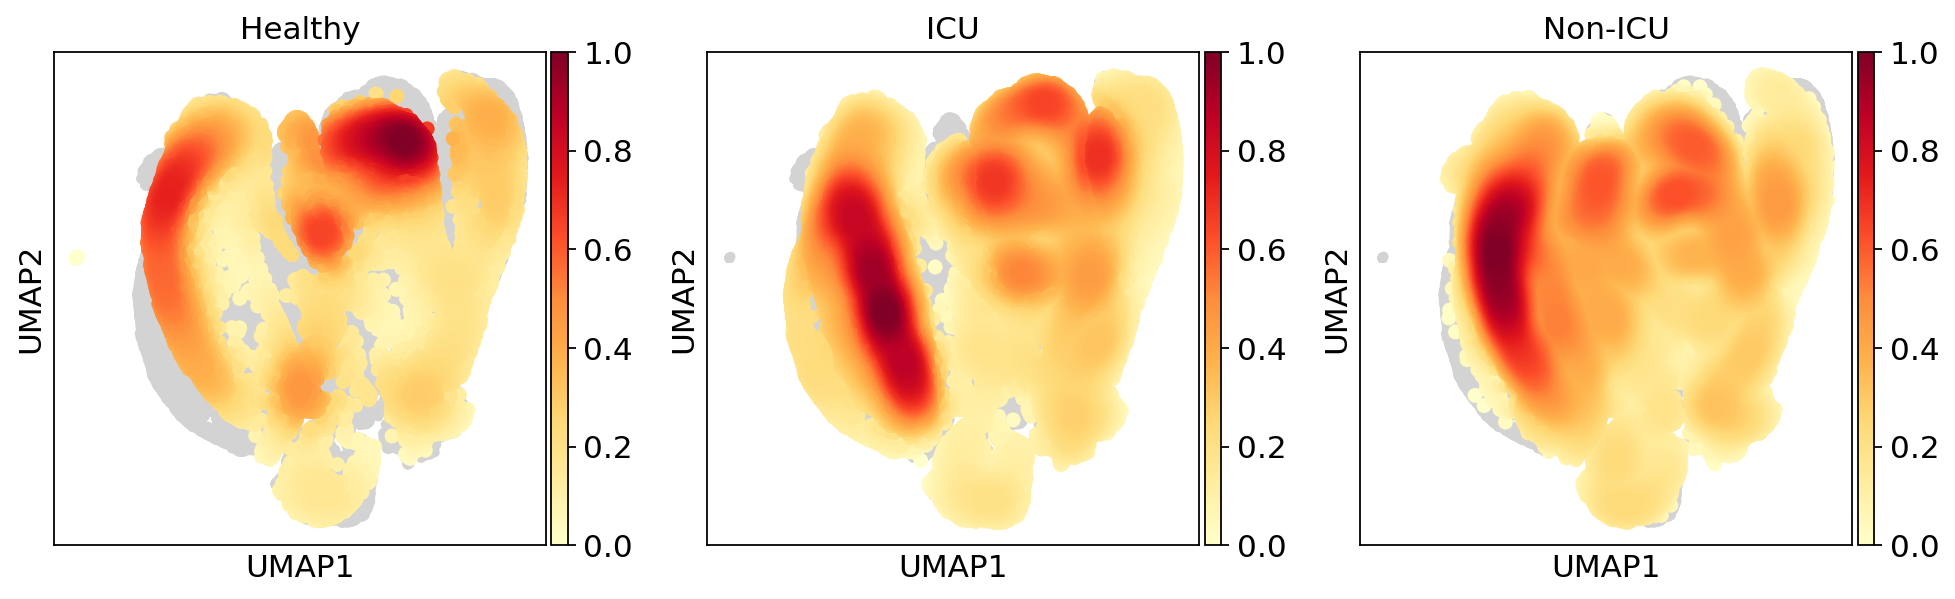

In [37]:
sc.pl.embedding_density(adata, basis='umap', key='umap_density_ICU_status')

In [ ]:
#adata.write(master_dir + 'output/all-processed-analyzed.h5ad')

## Clustering by metabolic genes only

In [38]:
# New AnnData containing metabolic genes only
adata_metab = adata[:, adata.var_names.isin(metab_gene_list)]

In [39]:
sc.tl.pca(adata_metab, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:32)


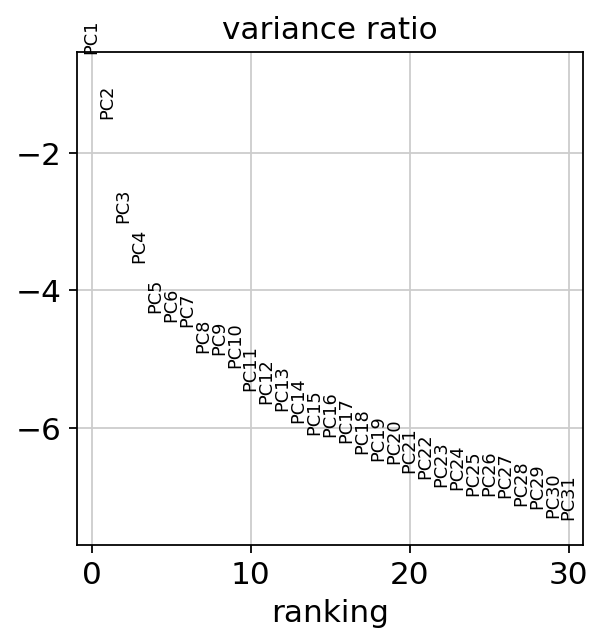

In [40]:
sc.pl.pca_variance_ratio(adata_metab, log=True)

In [41]:
sc.pp.neighbors(adata_metab)
sc.tl.umap(adata_metab)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:56)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:05:09)


In [42]:
adata_metab.obs['louvain_all'] = adata_metab.obs['louvain'].copy()
adata_metab.obs = adata_metab.obs.drop(columns=['louvain'])

In [43]:
sc.tl.louvain(adata_metab, resolution=0.1)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:57)


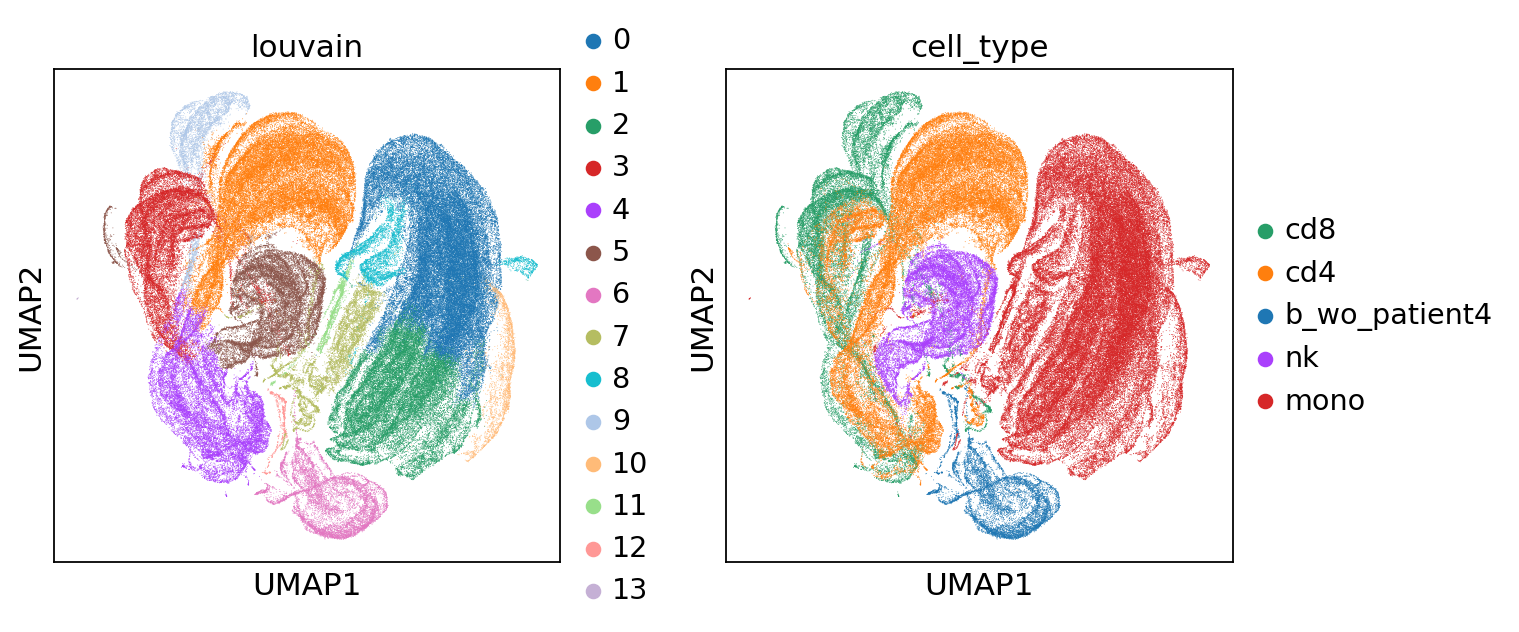

In [44]:
fig = sc.pl.umap(adata_metab, color=['louvain', 'cell_type'])

In [71]:
#adata_metab.write(master_dir + 'output/all-processed-analyzed-metab.h5ad')